## Train a machine learning model and Save in Tensorflow Lite

In [12]:
## Import dependencies
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.12.0


## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. We will use the dataset to train our digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.

In [13]:
# Keras provides a handy API to download the MNIST dataset, and split them into
# "train" dataset and "test" dataset.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [14]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


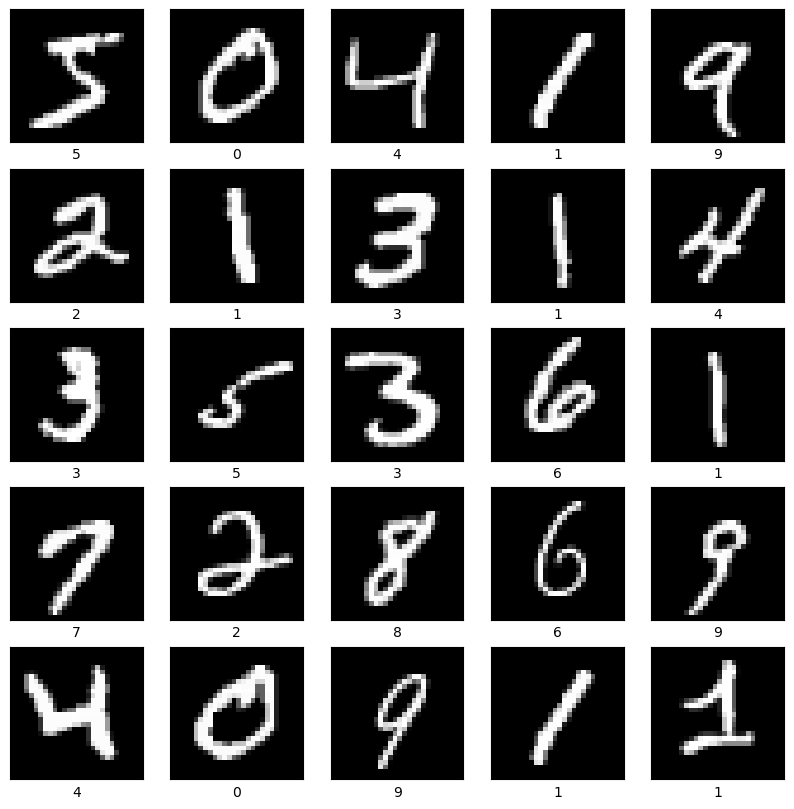

In [15]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Train a TensorFlow model to classify digit images

Next, we use Keras API to build a TensorFlow model and train it on the MNIST "train" dataset. After training, our model will be able to classify the digit images.

Our model takes **a 28px x 28px grayscale image** as an input, and outputs **a float array of length 10** representing the probability of the image being a digit from 0 to 9.

Here we use a simple convolutional neural network, which is a common technique in computer vision.


In [20]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=7)

Epoch 1/7
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1390 - accuracy: 0.9576
Epoch 2/7
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0533 - accuracy: 0.9840
Epoch 3/7
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0396 - accuracy: 0.9874
Epoch 4/7
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0313 - accuracy: 0.9901
Epoch 5/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0249 - accuracy: 0.9916
Epoch 6/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0202 - accuracy: 0.9937
Epoch 7/7
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0172 - accuracy: 0.9945


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                      

In [22]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9889
Test accuracy: 0.9889000058174133


313/313 [==============================] - 1s 4ms/step


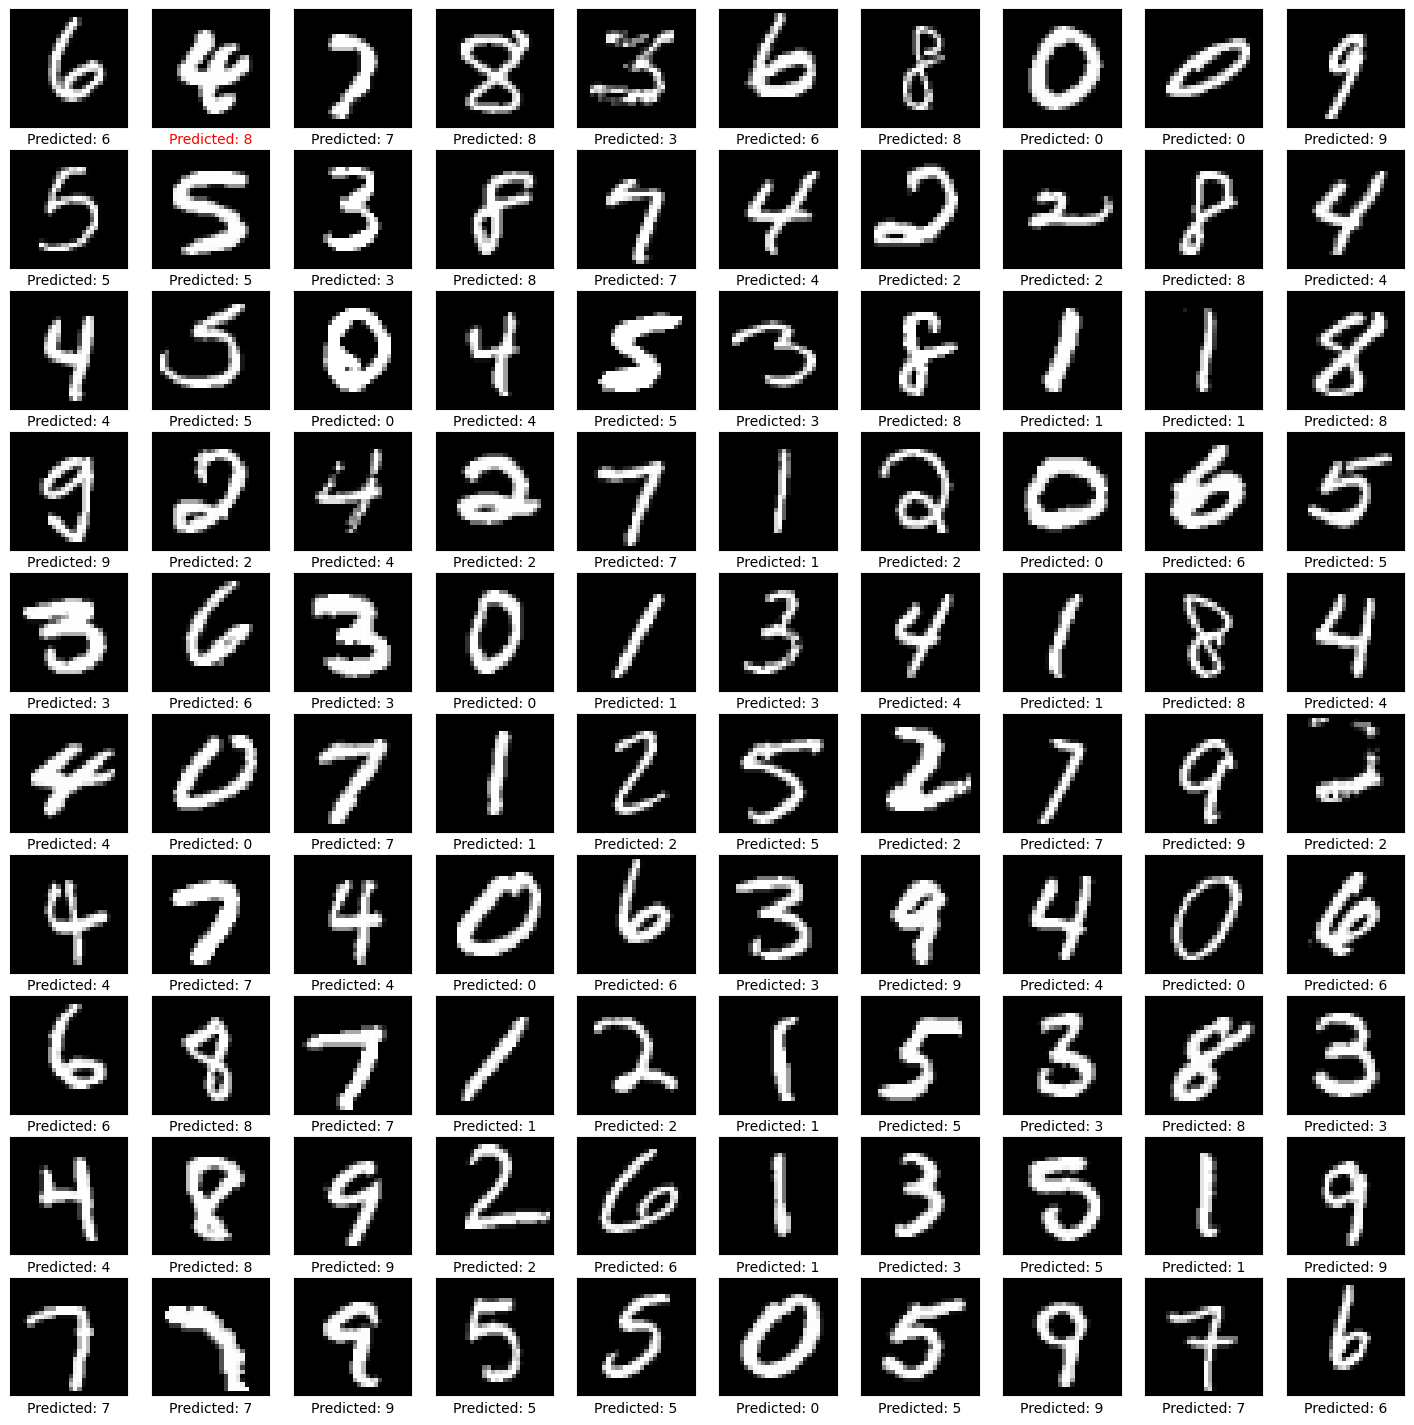

In [23]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Convert the Keras model to TensorFlow Lite
Now as we have trained the digit classifer model, we will convert it to TensorFlow Lite format for mobile deployment.

As we will deploy our model to a mobile device, we want our model to be as small and as fast as possible. Quantization is a common technique often used in on-device machine learning to shrink ML models. Here we will use 8-bit number to approximate our 32-bit weights, which in turn shrinks the model size by a factor of 4.

See TensorFlow documentation to learn more about other quantization techniques.

In [24]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

2024-03-23 23:44:21.528233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,28,28]
	 [[{{node input_2}}]]
2024-03-23 23:44:21.547423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,28,28]
	 [[{{node input_2}}]]
2024-03-23 23:44:21.554074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28,28]
	 [[{{node inputs}}]]
2024-0

INFO:tensorflow:Assets written to: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpd1s6xvi8/assets


INFO:tensorflow:Assets written to: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpd1s6xvi8/assets
2024-03-23 23:44:21.925185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input_2' with dtype float and shape [?,28,28]
	 [[{{node serving_default_input_2}}]]


Float model size = 437KBs.


2024-03-23 23:44:22.044047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-23 23:44:22.044064: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-23 23:44:22.044749: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpd1s6xvi8
2024-03-23 23:44:22.045648: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-03-23 23:44:22.045653: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpd1s6xvi8
2024-03-23 23:44:22.049481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2024-03-23 23:44:22.050094: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-23 23:44:22.080575: I tensorflow/cc/saved_model/loader.

In [25]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

2024-03-23 23:49:01.849348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,28,28]
	 [[{{node input_2}}]]
2024-03-23 23:49:01.871080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,28,28]
	 [[{{node input_2}}]]
2024-03-23 23:49:01.878096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,28,28]
	 [[{{node inputs}}]]
2024-0

INFO:tensorflow:Assets written to: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpa5p0zoc_/assets


2024-03-23 23:49:02.329360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input_2' with dtype float and shape [?,28,28]
	 [[{{node serving_default_input_2}}]]
INFO:tensorflow:Assets written to: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpa5p0zoc_/assets
2024-03-23 23:49:02.528829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input_2' with dtype float and shape [?,28,28]
	 [[{{node serving_default_input_2}}]]
2024-03-23 23:49:02.643733: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-23 23:49:02.643745: W tensorflow/comp

Quantized model size = 114KBs,
which is about 26% of the float model size.


2024-03-23 23:49:02.643880: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpa5p0zoc_
2024-03-23 23:49:02.644655: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-03-23 23:49:02.644660: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpa5p0zoc_
2024-03-23 23:49:02.647432: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-23 23:49:02.673280: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /var/folders/5m/7g056w7s7017wgnsbq1hvfwr0000gn/T/tmpa5p0zoc_
2024-03-23 23:49:02.680477: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 36598 microseconds.


## Evaluate the TensorFlow Lite model

By using quantization, we often traded off a bit of accuracy for the benefit of having a significantly smaller model. Let's calculate the accuracy drop of our quantized model.

In [27]:
# A helper function to evaluate the TF Lite model using "test" dataset.
# https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors() # Needed before execution!
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))

INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Failed to apply the default TensorFlow Lite delegate indexed at 0 because of incompatibility between runtime and delegate. Ignoring the error, and continuing anyway.


Float model accuracy = 0.9889


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.
INFO: Failed to apply the default TensorFlow Lite delegate indexed at 0 because of incompatibility between runtime and delegate. Ignoring the error, and continuing anyway.


Quantized model accuracy = 0.9887
Accuracy drop = 0.0002


## Download the TensorFlow Lite model

Let's get our model and integrate it into an Android app.

In [28]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

## Good job!
This is the end of **Train a machine learning model and save as tflite file** for **Build a handwritten digit classifier app with TensorFlow Lite**. Let's go back to the next step now!

## Download the Android skeleton app
Download a zip archive that contains the source code of the Android app used in this codelab. Extract the archive in your local machine.

# https://github.com/tensorflow/examples/archive/master.zip